In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(font_scale=1)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import math
from collections import OrderedDict 
import os
from random import randint
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.svm import SVC
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Reading The Data From Excel Sheet #
df = pd.read_excel('/content/UoC_dataset.xlsx')
df.head()

,State,Account length,Area code,Phone number,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Number customer service calls,Churner
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [3]:
def data_preprocess(df):
    drop_columns = ["State", "Phone number"]
    df = df.drop(drop_columns, axis=1)
    int_plan_yes = df["International plan"] == ' yes'
    int_plan_no = df["International plan"] == ' no'
    df["International plan"].values[int_plan_yes] = 1
    df["International plan"].values[int_plan_no] = 0
    voice_plan_no = df["Voice mail plan"] == ' no'
    voice_plan_yes = df["Voice mail plan"] == ' yes'
    df["Voice mail plan"].values[voice_plan_yes] = 1
    df["Voice mail plan"].values[voice_plan_no] = 0
    churner_yes = df['Churner'] == ' True.'
    churner_no = df['Churner'] == ' False.'
    df["Churner"].values[churner_yes] = 1
    df["Churner"].values[churner_no] = 0
    df['Churner'] = df['Churner'].apply(pd.to_numeric)
    return (df)

print("Number of churner yes: {}".format(df[df['Churner']==" True."].shape[0]))
print("Number of churner no: {}".format(df[df['Churner']==" False."].shape[0]))
minority=len(df[df['Churner'] == ' True.'])
majority=len(df[df['Churner'] == ' False.'])

Number of churner yes: 483
Number of churner no: 2850


In [4]:
df = data_preprocess(df)
scale = StandardScaler()

In [5]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Number customer service calls,Churner
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [6]:
features = df.iloc[:,0:18]
labels = df.iloc[:,18]
features_stand = scale.fit_transform(features) # standardization of feature values (mean=0, variance=1)
features = pd.DataFrame(features_stand , columns = features.columns)

In [7]:
print(features.shape)
print(labels.shape)

(3333, 18)
(3333,)


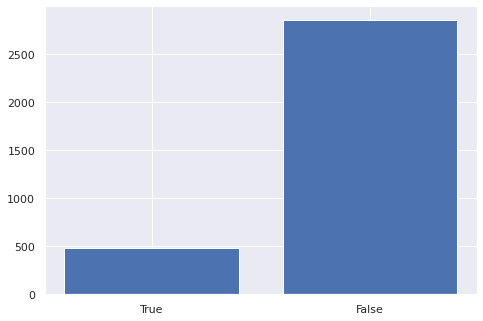

In [9]:
#Imbalanced Data
x = ["True" , "False"]
count_true = len(labels[ labels == 1 ])
count_false= len(labels[labels == 0  ])
y = [count_true , count_false]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.show()

In [10]:
df_train=pd.concat([features,labels],axis=1).ffill()

In [11]:
minority_df = df_train[ df_train["Churner"] == 1 ]
majority_df = df_train[ df_train["Churner"] == 0 ]


In [12]:
minority_df.shape

(483, 19)

In [13]:
def ret_random_k_nearest_neighbour( cur , minority_df , k ) :
    dict = {}
    for i in  range(0,minority_df.shape[0])  :
        dict[np.linalg.norm(cur-minority_df.iloc[i])] = minority_df.iloc[i].name 
    dict1 = sorted(dict.items()) 
    return dict1 

In [14]:
def solve(minority_df , want , k = 5  , sigma = 0.5 ):
    so_far = 0 
    dict = {}
    samples = []
    ss= StandardScaler()
    for i in  range(0,minority_df.shape[0])  :
            dict[minority_df.iloc[i].name] = ret_random_k_nearest_neighbour(minority_df.iloc[i] , minority_df , k )
    samples = []
    ss= StandardScaler()
    X_ss= ss.fit_transform(minority_df)
    while so_far != want :
      for i , j  in dict.items():
        value = randint( 0 , k - 1 ) # Normal distribution 
        entrydf = list(j)[value][1] 
        s0 = minority_df.loc[i] + (minority_df.loc[entrydf] - minority_df.loc[i]) * np.random.random_sample()
        R = np.random.normal( s0 , sigma )
        samples.append( R )
        so_far = so_far + 1
        if so_far == want :
          break
    return np.vstack( [ minority_df , ss.inverse_transform( np.vstack( samples ) ) ] )

In [15]:
E = solve( minority_df.iloc[:,0:18] , count_false - count_true  )
print( E.shape )

(2850, 18)


In [16]:
new_df = pd.DataFrame( E , columns = minority_df.columns[ : -1 ] )
new_df["Churner"] = 1

In [17]:
print(new_df.shape)
print(majority_df.shape)

(2850, 19)
(2850, 19)


In [18]:
new_df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Number customer service calls,Churner
0,-0.905784,-0.523603,-0.327580,-0.618396,-0.591760,-0.930515,1.822198,-0.930251,0.542727,-0.859168,0.542099,0.156784,0.556704,0.158501,0.882241,0.617898,0.882917,1.852927,1
1,1.505299,-0.523603,-0.327580,-0.618396,-0.591760,2.811735,-1.666277,2.811359,2.303852,-0.156344,2.303112,-0.796421,1.425573,-0.795122,-1.732915,1.836992,-1.730996,1.852927,1
2,-0.604398,-0.688834,-0.327580,-0.618396,-0.591760,-2.155284,-0.569899,-2.155132,-0.612949,1.048497,-0.613347,0.172604,-1.845462,0.171685,-1.625442,0.617898,-1.624847,2.613214,1
3,-2.236903,-0.688834,-0.327580,-0.618396,-0.591760,1.282150,0.875326,1.281879,1.014070,0.948094,1.013095,1.568792,-0.516604,1.569161,0.559825,-0.601195,0.564470,-0.427932,1
4,0.852298,-0.688834,3.052685,1.617086,2.403934,-0.122571,-0.769241,-0.122305,0.057580,0.345673,0.057183,-1.555821,-1.129923,-1.555384,1.562898,4.275179,1.559615,-1.188218,1


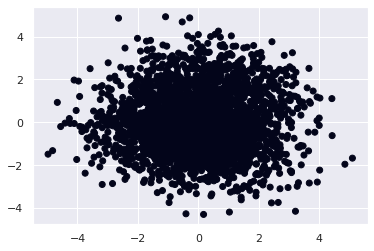

In [19]:
pca = PCA(n_components=2)
scale  = StandardScaler()
majority_df_ = scale.fit_transform(majority_df.iloc[:,0:18]) # standardization of feature values (mean=0, variance=1)
majority_df__ = pca.fit_transform(majority_df_) # fitting the model and reduction of the dimensionality
fig, ax = plt.subplots()
PCAplot = ax.scatter(majority_df__[:,0], majority_df__[:,1], c = majority_df.iloc[:,-1])
#PCAplot = ax.scatter(minority_df__[:,0], minority_df__[:,1], c = minority_df.iloc[:,-1] )

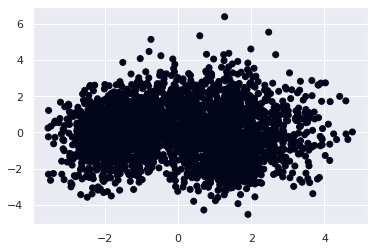

In [20]:
minority_df_ = scale.fit_transform(new_df.iloc[:,0:18])
minority_df__ = pca.fit_transform(minority_df_)
fig, ax = plt.subplots()
PCAplot = ax.scatter(minority_df__[:,0], minority_df__[:,1], c = new_df.iloc[:,-1])


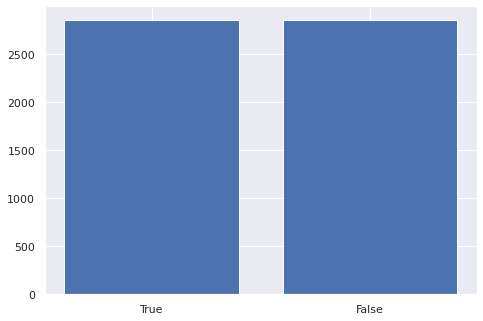

In [21]:
#Balanced Data
all_df = pd.concat( [new_df , majority_df] )
all_df.head()
x = ["True" , "False"]
count_true = len(all_df[ all_df["Churner"] == 1 ])
count_false= len(all_df[ all_df["Churner"] == 0  ])
y = [count_true , count_false]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.show()

In [22]:
shuffled_df = all_df.sample(frac=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.iloc[:,0:18] , shuffled_df.iloc[:,-1] , test_size=.40, random_state=0)

In [24]:
# Calculation of metrics
def metricsCalculation(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f =  f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    g_mean = np.sqrt((tp/(tp+fn)*(tn/(tn+fp))))
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    # Metrics aggregation into dataframe
    res = pd.DataFrame()
    res['OA'] = [acc]
    res['Precision'] = [precision]
    res['Recall'] = [recall]
    res['F measure'] = [f]
    res['G mean'] = [g_mean]
    res['AUC'] = [roc_auc]
    print(confusion_matrix(y_test,y_pred))

    print (res)

In [25]:
from time import *
print("# Train Decision trees  #")


tree_clf = DecisionTreeClassifier(max_depth=10, max_features=5, min_samples_leaf=3)
t0 = time()
tree_clf.fit(X_train, y_train)
t = time() - t0
y_pred = tree_clf.predict(X_test)

metricsCalculation(y_test, y_pred)

t=str(t)
print("Execution Time for GBM with default parameters is : "+t+" seconds")
import os
import psutil


#process = psutil.Process(os.getpid())
#print("Memory Usage for DT is ")
#print(process.memory_info().rss)  # in bytes 
#print(process.memory_percent())   # in percentage
#print("Execution Time for DT is : ")
#print(t)

#to print confusion matrix componenets 
cm = confusion_matrix(y_test, y_pred)
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])

# to do some calucations such as acccuracy 
confusion = confusion_matrix(y_test, y_pred)
# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
# to check the value of the accuracy
print((TP + TN) / float(TP + TN + FP + FN))

Error_rate= (FP+FN)/(TP + TN + FN + FP)
print ('Error rate is = ', Error_rate)

correct_rate=1-Error_rate
print ('correct rate is = ', correct_rate)

#Type I Accuracy 
print (TP /(TP + FN))

#Type I I Accuracy
print (TN /(TN + FP))

# Train Decision trees  #
[[1102   43]
 [  56 1079]]
         OA  Precision    Recall  F measure    G mean       AUC
0  0.956579   0.961676  0.950661   0.956136  0.956535  0.956553
Execution Time for GBM with default parameters is : 0.017078638076782227 seconds
True positive =  1102
False positive =  43
False negative =  56
True negative =  1079
0.9565789473684211
Error rate is =  0.04342105263157895
correct rate is =  0.9565789473684211
0.9506607929515418
0.9624454148471616


In [26]:
from time import *
print("# Train Decision trees  #")
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier()
t0 = time()
bagging.fit(X_train, y_train)
t = time() - t0
y_pred = bagging.predict(X_test)
metricsCalculation(y_test, y_pred)
t=str(t)
print("Execution Time for Bagging with default parameters is : "+t+" seconds")
import os
import psutil
#process = psutil.Process(os.getpid())
#print("Memory Usage for DT is ")
#print(process.memory_info().rss)  # in bytes 
#print(process.memory_percent())   # in percentage
#print("Execution Time for DT is : ")
#print(t)

#to print confusion matrix componenets 
cm = confusion_matrix(y_test, y_pred)
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])

# to do some calucations such as acccuracy 
confusion = confusion_matrix(y_test, y_pred)
# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
# to check the value of the accuracy
print((TP + TN) / float(TP + TN + FP + FN))

Error_rate= (FP+FN)/(TP + TN + FN + FP)
print ('Error rate is = ', Error_rate)

correct_rate=1-Error_rate
print ('correct rate is = ', correct_rate)

#Type I Accuracy 
print (TP /(TP + FN))

#Type I I Accuracy
print (TN /(TN + FP))

# Train Decision trees  #
[[1124   21]
 [  48 1087]]
         OA  Precision    Recall  F measure   G mean       AUC
0  0.969737   0.981047  0.957709   0.969238  0.96961  0.969684
Execution Time for Bagging with default parameters is : 0.20610356330871582 seconds
True positive =  1124
False positive =  21
False negative =  48
True negative =  1087
0.9697368421052631
Error rate is =  0.030263157894736843
correct rate is =  0.9697368421052631
0.9577092511013215
0.9816593886462882


In [33]:
print("# Train SVM  #")
from time import *
svclassifier = SVC(kernel='rbf',C=1000,gamma= 0.01) 
t0 = time()
svclassifier.fit(X_train, y_train)
t = time() - t0
y_pred = svclassifier.predict(X_test)
metricsCalculation(y_test, y_pred)
t=str(t)
print("Execution Time for Bagging with default parameters is : "+t+" seconds")
import os
import psutil
#process = psutil.Process(os.getpid())
#print("Memory Usage for DT is ")
#print(process.memory_info().rss)  # in bytes 
#print(process.memory_percent())   # in percentage
#print("Execution Time for DT is : ")
#print(t)
#to print confusion matrix componenets 
cm = confusion_matrix(y_test, y_pred)
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])
# to do some calucations such as acccuracy 
confusion = confusion_matrix(y_test, y_pred)
# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
# to check the value of the accuracy
print((TP + TN) / float(TP + TN + FP + FN))
Error_rate= (FP+FN)/(TP + TN + FN + FP)
print ('Error rate is = ', Error_rate)
correct_rate=1-Error_rate
print ('correct rate is = ', correct_rate)
#Type I Accuracy 
print (TP /(TP + FN))
#Type I I Accuracy
print (TN /(TN + FP))

# Train SVM  #
[[1091   54]
 [  97 1038]]
         OA  Precision    Recall  F measure    G mean       AUC
0  0.933772   0.950549  0.914537   0.932196  0.933492  0.933688
Execution Time for Bagging with default parameters is : 1.291262149810791 seconds
True positive =  1091
False positive =  54
False negative =  97
True negative =  1038
0.9337719298245614
Error rate is =  0.0662280701754386
correct rate is =  0.9337719298245614
0.9145374449339208
0.9528384279475982
